In [190]:
import pandas as pd
import numpy as np
import os

def pred_dataset(file_names):
    source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for file_name in file_names:
        temp_data = pd.read_excel(os.path.join(source_path,file_name+'-02-02-2022.xlsx'),skiprows= 1 )
        
        temp_data = temp_data.dropna(axis=0,how = 'any',subset = ["BET",'Vt'])
        #temp_data = temp_data[temp_data['Pressure']>0.01]
        #temp_data = temp_data[temp_data['Vmic']<2]
        index = list(set(temp_data['Index'].values))
        print(len(index))
        test_index= np.random.choice(index,int(0.2*len(index)),replace=False)
        train_x = temp_data.loc[~temp_data['Index'].isin( test_index)]
        test_x = temp_data.loc[temp_data['Index'].isin(test_index)]
        
        train_df = pd.concat([train_df,train_x],axis=0)
        test_df = pd.concat([test_df,test_x],axis =0)
    return train_df,test_df

# A bagging approach using the kernel PCA

In [143]:
import numpy.random as nrd
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from  collections import Counter
def bgk_pca(train_df,test_df): 
    np.random.RandomState(42)# using major voting approach to find the outliers in the test dataset
    test_index = list(set(test_df["Index"].values))
    len_test = len(test_index)
    train_index = list(set(train_df["Index"].values))
    total_feature = ["Index",'BET','Vt','Temp(K)']
    pca_feature =  ['BET','Vt','Temp(K)']
    num_feature = len(pca_feature)
    removed_index = []
    res = []
    iters = 10
    for i in range(iters):
        mses = []
        train_selected = train_df[train_df["Index"].isin(nrd.choice(train_index,int(len_test*3.5),replace=False))]

        
        data = pd.concat([test_df,train_selected])
        sub_data = data[total_feature].drop_duplicates()
        sub_data_scalered = MinMaxScaler().fit_transform(sub_data[pca_feature].values) #MinMaxScaler

        """adding lines to determine the number of components to achieve 0.99 threshold"""
        kernel_pca = KernelPCA(kernel='poly',max_iter =100000,n_jobs =-1,gamma=1e-2,random_state=42)
        kpca_transform = kernel_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
        explained_variance = np.var(kpca_transform, axis=0)
        explained_variance_ratio = explained_variance / np.sum(explained_variance)
        cumu_variance = np.cumsum(explained_variance_ratio)
        n_components = np.where(cumu_variance>0.99)[0][0]+1
        kernel_pca = KernelPCA(n_components=n_components,kernel='poly',max_iter =100000,n_jobs =-1,gamma=1e-2,fit_inverse_transform=True,random_state=42)
        """ The end of adding new lines"""

        sub_data_transformed = kernel_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
        reconstructed = kernel_pca.inverse_transform(sub_data_transformed.reshape(num_feature,-1))
        for i in range(len(sub_data_scalered)):
            mses.append(mean_squared_error(sub_data_scalered[i],reconstructed.reshape(-1,num_feature)[i]))
            df_mse = pd.DataFrame(mses,columns = ['MSE'])
        df_mse['Indexs'] = sub_data["Index"].drop_duplicates().values
        mean_mse = df_mse["MSE"].mean()
        std_mse = df_mse['MSE'].std()
        test_mse_df = df_mse[df_mse["Indexs"].isin(test_index)]
        outlier_index = test_mse_df[test_mse_df["MSE"]>3*std_mse+mean_mse]["Indexs"].values.tolist()
        removed_index.extend(outlier_index)

    counter = Counter(removed_index)
    thresh = int(0.7*iters)
    for key,values in counter.most_common():
        if values>=thresh:
            res.append(key)
            
        if values<thresh: break

    return res

# The second kernel-pca

In [191]:
# This one works well for methane
import numpy.random as nrd
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from  collections import Counter
def bgk_pca(train_df,test_df): 
    np.random.RandomState(42)# using major voting approach to find the outliers in the test dataset
    test_index = list(set(test_df["Index"].values))
    len_test = len(test_index)
    train_index = list(set(train_df["Index"].values))
    total_feature = ["Index",'BET','Vt','Temp(K)']
    pca_feature =  ['BET','Vt','Temp(K)']
    num_feature = len(pca_feature)
    removed_index = []
    res = []
    iters = 10
    for i in range(iters):
        mses = []
        train_selected = train_df[train_df["Index"].isin(nrd.choice(train_index,int(len_test*3.5),replace=False))]
        train_selected = train_selected[total_feature].drop_duplicates()
        test_df = test_df[total_feature].drop_duplicates()
        #print(train_selected.shape,test_df.shape)

        #data = pd.concat([test_df,train_selected])
        #sub_data = data[total_feature].drop_duplicates()
        scaler = MinMaxScaler()
        train_data_scalered = scaler.fit_transform(train_selected[pca_feature].values) #MinMaxScaler
        test_data_scalered = scaler.transform(test_df[pca_feature].values)
        #print(train_data_scalered.shape,test_data_scalered.shape)
        sub_data_scalered = np.append(train_data_scalered,test_data_scalered,axis =0)

        """adding lines to determine the number of components to achieve 0.99 threshold"""
        kernel_pca = KernelPCA(kernel='poly',max_iter =100000,n_jobs =-1,gamma=1e-2,random_state=42)
        kpca_transform = kernel_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
        explained_variance = np.var(kpca_transform, axis=0)
        explained_variance_ratio = explained_variance / np.sum(explained_variance)
        cumu_variance = np.cumsum(explained_variance_ratio)
        n_components = np.where(cumu_variance>0.99)[0][0]+1
        kernel_pca = KernelPCA(n_components=n_components,kernel='poly',max_iter =100000,n_jobs =-1,gamma=1e-2,fit_inverse_transform=True,random_state=42)
        """ The end of adding new lines"""

        sub_data_transformed = kernel_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
        reconstructed = kernel_pca.inverse_transform(sub_data_transformed.reshape(num_feature,-1))
        for i in range(len(sub_data_scalered)):
            mses.append(mean_squared_error(sub_data_scalered[i],reconstructed.reshape(-1,num_feature)[i]))
            df_mse = pd.DataFrame(mses,columns = ['MSE'])
        
        df_mse['Indexs'] = train_selected['Index'].values.tolist()+test_index#sub_data["Index"].drop_duplicates().values
        mean_mse = df_mse["MSE"].mean()
        std_mse = df_mse['MSE'].std()
        test_mse_df = df_mse[df_mse["Indexs"].isin(test_index)]
        outlier_index = test_mse_df[test_mse_df["MSE"]>2*std_mse+mean_mse]["Indexs"].values.tolist()
        removed_index.extend(outlier_index)

    counter = Counter(removed_index)
    thresh = int(0.7*iters)
    for key,values in counter.most_common():
        if values>=thresh:
            res.append(key)
            
        if values<thresh: break

    return res

# The third kernel-pca

In [145]:
import numpy.random as nrd
from sklearn.decomposition import KernelPCA,SparsePCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from  collections import Counter

def bgk_pca(train_df,test_df): 
    #np.random.RandomState(42)# using major voting approach to find the outliers in the test dataset
    test_index = list(set(test_df["Index"].values))
    len_test = len(test_index)
    train_index = list(set(train_df["Index"].values))
    #total_feature = ["Index",'V','L','BET','Vt','Temp(K)']
    total_feature = ["Index",'BET','Vt','Temp(K)']
    #pca_feature =  ['V','L','BET','Vt','Temp(K)']
    pca_feature =  ['BET','Vt','Temp(K)']
    num_feature = len(pca_feature)
    removed_index = []
    res = []
    iters = 10
    multi_mse = []
    for i in range(iters):
        mses = []
        train_selected = train_df[train_df["Index"].isin(nrd.choice(train_index,int(len(train_index)*0.75),replace=False))] # modified here change fixed len to a the fraction of the len of the training dataset.
        data = pd.concat([test_df,train_selected])
        sub_data = data[total_feature].drop_duplicates()
        sub_data_scalered = MinMaxScaler().fit_transform(sub_data[pca_feature].values)
        
        """adding lines to determine the number of components to achieve 0.99 threshold"""
        kernel_pca = KernelPCA(kernel='poly',max_iter =100000,n_jobs =-1,gamma=1e-2,fit_inverse_transform=True,random_state=42)
        kpca_transform = kernel_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
        explained_variance = np.var(kpca_transform, axis=0)
        explained_variance_ratio = explained_variance / np.sum(explained_variance)
        cumu_variance = np.cumsum(explained_variance_ratio)
        n_components = np.where(cumu_variance>0.99)[0][0]+1
        kernel_pca = KernelPCA(n_components=n_components,kernel='poly',max_iter =100000,n_jobs =-1,gamma=1e-2,fit_inverse_transform=True,random_state=42)
        """ The end of adding new lines"""

        sub_data_transformed = kernel_pca.fit_transform(sub_data_scalered.reshape(num_feature,-1))
        reconstructed = kernel_pca.inverse_transform(sub_data_transformed.reshape(num_feature,-1))
        for i in range(len(sub_data_scalered)):
            mses.append(mean_squared_error(sub_data_scalered[i],reconstructed.reshape(-1,num_feature)[i]))
            df_mse = pd.DataFrame(mses,columns = ['MSE'])
        df_mse['Indexs'] = sub_data["Index"].drop_duplicates().values
        mean_mse = df_mse["MSE"].mean()
        test_mse_df = df_mse[df_mse["Indexs"].isin(test_index)]
        outlier_index = test_mse_df[test_mse_df["MSE"]>3*mean_mse]["Indexs"].values.tolist()
        removed_index.extend(outlier_index)
        multi_mse.append(mean_mse)

    counter = Counter(removed_index)
    thresh = int(0.7*iters)
    for key,values in counter.most_common():
        if values>=thresh:
            res.append(key)
            
        if values<thresh: break

    return res

In [153]:
train_df,test_df = pred_dataset(['CFCs'])
index_dropped = bgk_pca(train_df,test_df)
test_df_m = test_df[~test_df["Index"].isin(index_dropped)]
len(test_df_m)


115


In [192]:
from sklearn.ensemble import GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor
from lightgbm import LGBMRegressor  
  
n_estimators = [50,100,120,150,180,200]

# define different models#,
models = [
    #("GBR",GradientBoostingRegressor(random_state=42)),\
    #('ETR',ExtraTreesRegressor(random_state=42,n_jobs=-1)),\
   # ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42)),\
    ('BGLGBM',BaggingRegressor(LGBMRegressor(n_estimators = 200, n_jobs = -1,random_state = 42), random_state=42,n_jobs=-1)),\
    ]
# set search parameters grid for different models
para_grids = { 
    'GBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2]},\
    'ETR':{'n_estimators':n_estimators},\
    'LGBM':{'num_leaves':[10,20,30,50],'learning_rate': [0.05,0.1,0.5,1],'n_estimators':n_estimators},\
    'BGLGBM':{'n_estimators':[10,30,50]},\
    }

In [193]:
from sklearn.model_selection import GridSearchCV,cross_validate,GroupKFold
from sklearn.ensemble import ExtraTreesRegressor
from  sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def model_CV(train_x,train_y,groups,model,para_grid):
    np.random.RandomState(42)

    out_cv = GroupKFold(n_splits = 5)
    result = GridSearchCV(model,para_grid,cv= out_cv.get_n_splits(groups =groups),
    scoring='neg_mean_squared_error', return_train_score=True,n_jobs=-1)
    result.fit(train_x,train_y)
    
    model_refit =model.set_params(**result.best_params_)
    train_cv = cross_validate(model_refit,train_x,train_y,groups = groups,cv =out_cv,scoring = ('r2', 'neg_mean_squared_error'))
    train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
    train_r2_cv = train_cv['test_r2'].mean()
    
    return [train_r2_cv,train_mse_cv],result.best_params_

# model evaluation
def model_eval(model,test_x,test_y):

    test_pre = model.predict(test_x)
    plt.scatter(test_pre,test_y,alpha=0.5)
    test_r2 = r2_score(test_pre,test_y)
    test_mse = mean_squared_error(test_y,test_pre)
    return test_r2,test_mse

# comparing different models
def model_comparison(model_list,para_grids,feature_list,gas_list):
    gas_list = gas_list 
    input_feature = feature_list
    output = ['Adsorp(mmol/g)']
    result_total = []

    for gas in gas_list:
        
        if gas =='total':

            train_df_com = train_df
            test_df_com = test_df
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            groups = train_df_com['Index'].values
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
            
            for model_name, model in model_list:

                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2_total,test_mse_total = model_eval(model_refit,test_x,test_y.squeeze()) 
                for gases in gas_list[1:]:
                    test_df_com = test_df[test_df['Label']==gases]
                    test_xs = test_df_com[input_feature]
                    test_ys = test_df_com[output].values
                    test_r2,test_mse = model_eval(model_refit,test_xs,test_ys.squeeze()) 
                    result_total.append([gases,model_name+'_total',result[0],result[1],test_r2_total,test_mse_total,test_r2,test_mse,best_param])

                    print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))    
        
        else:
            train_df_com = train_df[train_df['Label']==gas]
            test_df_com = test_df[test_df['Label']==gas]
            test_df_droped = test_df_m[test_df_m['Label']==gas]
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            test_x_m = test_df_droped[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            test_y_m = test_df_droped[output].values
            groups = train_df_com['Index']
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
           
            for model_name, model in model_list:

                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2,test_mse = model_eval(model_refit,test_x,test_y.squeeze()) 
                test_r2_m,test_mse_m = model_eval(model_refit,test_x_m,test_y_m.squeeze()) 
                result_total.append([gas,model_name+'_separate',result[0],result[1],-1,-1, test_r2,test_mse,test_r2_m,test_mse_m,best_param])
                
                print('Dataset {:2s}, Algorithm {:2s}, Test_r2 {:.4f}, Test_error {:.4f}, Test_r2_m {:.4f}, Test_error_m {:.4f}'.format(gas,model_name+'_total',\
                        test_r2,test_mse,test_r2_m,test_mse_m,))
                    

                
    return result_total

In [194]:
import pandas as pd
import numpy as np
import os

def pred_dataset(file_names):
    source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for file_name in file_names:
        temp_data = pd.read_excel(os.path.join(source_path,file_name+'-02-02-2022.xlsx'),skiprows= 1 )
        
        temp_data = temp_data.dropna(axis=0,how = 'any',subset = ["BET",'Vt',])
        #temp_data = temp_data[temp_data['Pressure']>0.01]
        #temp_data = temp_data[temp_data['Vmic']<2]
        index = list(set(temp_data['Index'].values))
        temp_index= np.random.choice(index,200,replace=False)
        temp_data = temp_data.loc[temp_data['Index'].isin(temp_index)]
        index = list(set(temp_data['Index'].values))
        print(len(index))
        test_index= np.random.choice(index,int(0.2*len(index)),replace=False)
        train_x = temp_data.loc[~temp_data['Index'].isin( test_index)]
        test_x = temp_data.loc[temp_data['Index'].isin(test_index)]
        
        train_df = pd.concat([train_df,train_x],axis=0)
        test_df = pd.concat([test_df,test_x],axis =0)
    return train_df,test_df

200
0
Dataset E&E, Algorithm BGLGBM_total, Test_r2 0.8966, Test_error 0.7859, Test_r2_m 0.8966, Test_error_m 0.7859
200
0
Dataset E&E, Algorithm BGLGBM_total, Test_r2 0.9267, Test_error 0.6342, Test_r2_m 0.9267, Test_error_m 0.6342


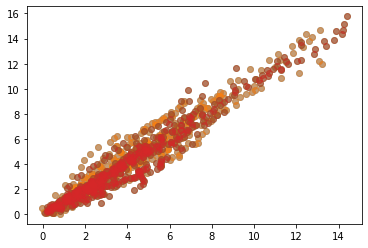

In [195]:
import os
base_feature = ['V','S','L','BET',]
condition_feature = ['Temp(K)','Pressure']
combin_1 = ['Vt']
combin_2 = ["Vmeso"]
combin_3 = ['Vmic']
combin_4 = ['Vt',"Vmeso",]
combin_3 = ['Vt',"Vmic",]
combin_5 = ['Vt',"Vmic",'Vmeso',]
combin_6 = ["Vmic",'Vmeso',]
feature_list = [base_feature+combin_1+condition_feature,]
columns = ['Gas','Model_name','CV_r2','CV_mse','test_r2_total_model','test_mse_by_total_model',\
    'test_r2_separa_model','test_mse_separa_model','test_r2_separa_model_m','test_mse_separa_model_m','best_param']
    
file_name = ['BET_plus_Vt']
feature_set = ["BET","Vt",] 
gas_list = ['E&E']
droped_nums = 0

for i in range(2):
    train_df,test_df = pred_dataset(['Ethane&Ethylene'])
    index_dropped = bgk_pca(train_df,test_df)
    print(len(index_dropped))
    test_df_m = test_df[~test_df["Index"].isin(index_dropped)]
    #train_df,test_df = train_df,test_df_m#data_split(data,removed_index=index_removed)
    droped_nums+=len(index_dropped)
    for j in range(len(feature_list)):
        results = model_comparison(models,para_grids, feature_list[j],gas_list)
        files_name = 'Dropping_outliers_with_bgk_'+file_name[j]+'_result_'+str(i)+'.csv'
        pd.DataFrame(results,columns = columns).to_csv(os.path.join('./5_kernel_pca',files_name)) 

In [161]:
droped_nums

68

In [162]:
import pandas as pd
file_name = ['BET_plus_Vt']
df_list = []
cal_columns= ["CV_r2","CV_mse","test_r2_separa_model","test_mse_separa_model",'test_r2_separa_model_m','test_mse_separa_model_m',] 
for j in range(len(file_name)):
    for i in range(15):
        files_name = 'Dropping_outliers_with_bgk_'+file_name[j]+'_result_'+str(i)+'.csv'
        df_list.append(pd.read_csv(os.path.join('./5_kernel_pca',files_name))[cal_columns] )
        pd.concat(df_list).groupby(level=0).mean().to_csv(os.path.join('./5_kernel_pca',file_name[j]+'_mean.csv'))
        pd.concat(df_list).groupby(level=0).std().to_csv(os.path.join('./5_kernel_pca',file_name[j]+'_std.csv'))

In [ ]:
def data_split(df,removed_index = None):
    if removed_index!= None:
        temp_data = df.loc[~df["Index"].isin(removed_index)]
    else: temp_data = df
    index = list(set(temp_data['Index'].values))
    print(len(index))
    test_index= np.random.choice(index,int(0.2*len(index)),replace=False)
    train_x = temp_data.loc[~temp_data['Index'].isin( test_index)]
    test_x = temp_data.loc[temp_data['Index'].isin(test_index)]
    return train_x,test_x